In [1]:
import pickle 
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import models.custom.detector as g
from libs.dataset_utils import prepare_data_from_tfrecord
from libs.image_utils import (get_random_patch_list,
                              draw_bounding_box,
                              calc_iou_accuracy,
                              calc_iou_top_1_accuracy)
from libs.various_utils import load_from_pickle
from configs.project_config import project_path
from helpers import (evaluate,
                     visualize,
                     visualize_cam,
                     restore_preprocessed)

In [2]:
"""
Constant
"""
NUM_CLASS = 200
INPUT_SHAPE = (64, 64, 3)
MODEL_BASE_INPUT_SHAPE = (224, 224, 3)

tfrecord_train_dir = "{}/data/tiny-imagenet-200/tfrecord/train".format(project_path)
tfrecord_valid_dir = "{}/data/tiny-imagenet-200/tfrecord/valid".format(project_path)
tfrecord_test_dir = "{}/data/tiny-imagenet-200/tfrecord/test".format(project_path)

meta_path = "{}/data/tiny-imagenet-200/meta.pickle".format(project_path)
pretrained_ckpt_path = "{}/checkpoints/inception_v3/inception_v3.ckpt".format(project_path)

has_model_save_path = "{}/checkpoints/has_inception_v3/has_inception_v3".format(project_path)
has_pretrained_path = "{}/checkpoints/pretrained/has_inception_v3/has_inception_v3".format(project_path)

pickle_data_full_path = "{}/data/tiny-imagenet-200/pickle/tiny_imagenet.pickle".format(project_path)

# Build Model, Dataset Pipeline and Load Pretrained Inception Weights

In [3]:
# ==============================================================================
# model_base_name : { "InceptionV3", "InceptionV2", "alexnet_v2"}
# 각 모델마다 final endpoint를 변경할 수 있다. final endpoint 의 정보는 models/안에 모델별 폴더안의 python 파일에 들어있다.
model_base_name = "InceptionV3"
model = g.Detector(output_dim=NUM_CLASS,
                   input_shape=INPUT_SHAPE,
                   model_base_input_shape=MODEL_BASE_INPUT_SHAPE,
                   model_base_name=model_base_name,
                   model_name="hide_and_seek")

X_preprocessed shape: [None, 224, 224, 3]
last_conv shape : [None, 5, 5, 1024]
gap shape :[None, 1, 1, 1024]
h shape :[None, 1, 1, 1024]
logits_before shape :[None, 1, 1, 200]
logits shape :[None, 200]
W shape :[1, 1, 1024, 200]
class_weight_by_row shape : [200, 1024]
batch_class_weight shape : [None, 1024, 1]
last_conv_flatten_w_h shape : [None, 4096, 1024]
clf_var_to_optimize_list
[<tf.Variable 'clf/conv/weights:0' shape=(3, 3, 2048, 1024) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/beta:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/moving_mean:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/moving_variance:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/logits/weights:0' shape=(1, 1, 1024, 200) dtype=float32_ref>,
 <tf.Variable 'clf/logits/biases:0' shape=(200,) dtype=float32_ref>]


In [4]:
# ==============================================================================
"""
Load Model
"""
try :
    d = load_from_pickle(pickle_data_full_path)
    (X_train, P_train, Y_train, Y_train_one_hot) = (d['X_train'], d['P_train'], d['Y_train'] ,d['Y_train_one_hot'])
    (X_valid, P_valid, Y_valid, Y_valid_one_hot) = (d['X_valid'], d['P_valid'], d['Y_valid'] ,d['Y_valid_one_hot'])
    (X_test, P_test, Y_test, Y_test_one_hot) = (d['X_test'], d['P_test'], d['Y_test'] ,d['Y_test_one_hot'])
    (idx_word_dict, word_idx_dict) = (d['idx_word_dict'], d['word_idx_dict'])
    (idx_nid_dict, nid_idx_dict) = (d['idx_nid_dict'], d['nid_idx_dict'])
except Exception as e: 
    print("maybe there is no pickle data: {}".format(e))

In [5]:
# ==============================================================================
with model.g.as_default():
    """
    Read Data
    """
    d = prepare_data_from_tfrecord(
        tfrecord_train_dir=tfrecord_train_dir,
        tfrecord_valid_dir=tfrecord_valid_dir,
        tfrecord_test_dir=tfrecord_test_dir,
        batch_size=64,
        shuffle_buffer_size=1000)
    (X, Y,
     init_dataset_train,
     init_dataset_train_has,
     init_dataset_valid) = (d['X'], d['Y'],
                            d['init_dataset_train'],
                            d['init_dataset_train_has'],
                            d['init_dataset_valid'])

    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    model.meta.update(meta)

    """
    Initialize with pretrained weights
    """
    variables_to_restore = tf.contrib.framework.get_variables_to_restore(
        include=[model_base_name])
    init_pretrain_fn = tf.contrib.framework.assign_from_checkpoint_fn(
        pretrained_ckpt_path, variables_to_restore)

    init_pretrain_fn(model.sess)

INFO:tensorflow:Restoring parameters from /home/sungju/projects/sj/hide_and_seek/checkpoints/inception_v3/inception_v3.ckpt


# Make Sample Data

In [6]:
model.sess.run(init_dataset_train)
X_sample_preprocessed, Y_sample_one_hot = model.sess.run([X, Y])
X_sample =restore_preprocessed(X_sample_preprocessed)
Y_sample = np.argmax(Y_sample_one_hot, axis=1)

# HaS input Test

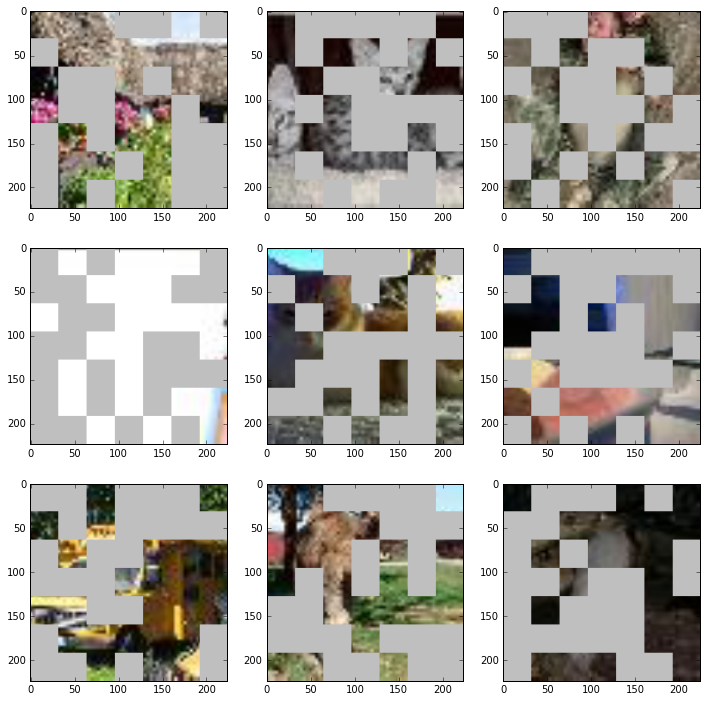

In [7]:
model.sess.run(init_dataset_train_has)
X_sample = model.sess.run(X)
X_sample_restored =(X_sample*0.5+0.5)*255
X_sample_restored = X_sample_restored.astype(np.uint8)
fig, axs = plt.subplots(3,3, figsize=(12,12))
for y in range(3):
    for x in range(3):
        sample = X_sample_restored[x+(y%3)*3]
        axs[y][x].imshow(X_sample_restored[x+(y%3)*3])

# Hide and Seek

In [16]:
# ==============================================================================
"""
If you use pretrained model, you can train only top classifier layer.
"""
model.train_with_dataset_api(X=X,
                             Y=Y,
                             init_dataset_train=init_dataset_train,
                             init_dataset_valid=init_dataset_valid,
                             n_epoch=20,
                             learning_rate=0.001,
                             reg_lambda=0.,
                             dropout_keep_prob=0.8,
                             patience=10,
                             verbose_interval=1,
                             mode=g.MODE_TRAIN_ONLY_CLF,
                             save_dir_path=None)




  0%|          | 0/20 [00:00<?, ?it/s]

******************************
Make directory with save_dir_path is failed
Maybe, there is directory already or error because of "[Errno 17] File exists: './tmp/20180905_233733_A219FW'"





epoch 0, batch 0 takes: 2.34 sec:   0%|          | 0/20 [00:02<?, ?it/s]


epoch 0, batch 1 takes: 0.41 sec:   0%|          | 0/20 [00:02<?, ?it/s]


epoch 0, batch 2 takes: 0.40 sec:   0%|          | 0/20 [00:03<?, ?it/s]


epoch 0, batch 3 takes: 0.41 sec:   0%|          | 0/20 [00:03<?, ?it/s]


epoch 0, batch 4 takes: 0.40 sec:   0%|          | 0/20 [00:03<?, ?it/s]


epoch 0, batch 5 takes: 0.40 sec:   0%|          | 0/20 [00:04<?, ?it/s]


epoch 0, batch 6 takes: 0.40 sec:   0%|          | 0/20 [00:04<?, ?it/s]


epoch 0, batch 7 takes: 0.40 sec:   0%|          | 0/20 [00:05<?, ?it/s]


epoch 0, batch 8 takes: 0.40 sec:   0%|          | 0/20 [00:05<?, ?it/s]


epoch 0, batch 9 takes: 0.40 sec:   0%|          | 0/20 [00:06<?, ?it/s]


epoch 0, batch 10 takes: 0.39 sec:   0%|          | 0/20 [00:06<?, ?it/s]


epoch 0, batch 11 takes: 0.40 sec:   0%|          | 0/20 [00:06<?, ?it/s]


epoch 0, batch 12 takes: 0.40 sec:   0%|          | 0/20 [00:07<?, ?it/s]


epoch 0, batch 13 t

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-363ba441b45f>", line 16, in <module>
    save_dir_path=None)
  File "/home/sungju/projects/sj/hide_and_seek/models/custom/detector.py", line 483, in train_with_dataset_api
    self.is_training: True})
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 889, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1120, in _run
    feed_dict_tensor, options, run_metadata)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1317, in _do_run
    options, run_metadata)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1323, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.5/dist-packa

KeyboardInterrupt: 

In [ ]:
model.train_with_dataset_api(X=X,
                             Y=Y,
                             init_dataset_train=init_dataset_train_has,
                             init_dataset_valid=init_dataset_valid,
                             n_epoch=1,
                             learning_rate=0.001,
                             reg_lambda=0.,
                             dropout_keep_prob=0.8,
                             patience=10,
                             verbose_interval=1,
                             mode=g.MODE_TRAIN_GLOBAL,
                             save_dir_path=None)

In [ ]:
model.save(has_model_save_path)

# Run Sample

In [12]:
# ==============================================================================
num_sample = 100
X_sample =  X_train[:num_sample]
P_sample = P_train[:num_sample]
Y_sample_one_hot = Y_train_one_hot[:num_sample]
Y_sample = Y_train[:num_sample]

In [13]:
(cam_list_sample,
bbox_list_sample,
gt_known_loc_accuracy_sample,
top_1_loc_accuracy_sample) = evaluate(model, X_sample, P_sample, Y_sample_one_hot, 'sample')

GT-known-Loc sample iou_accuracy : 0.57
Top-1 Loc sample iou_accuracy : 0.0


(<matplotlib.figure.Figure at 0x7f293478dda0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f27ec63c390>,
       dtype=object))

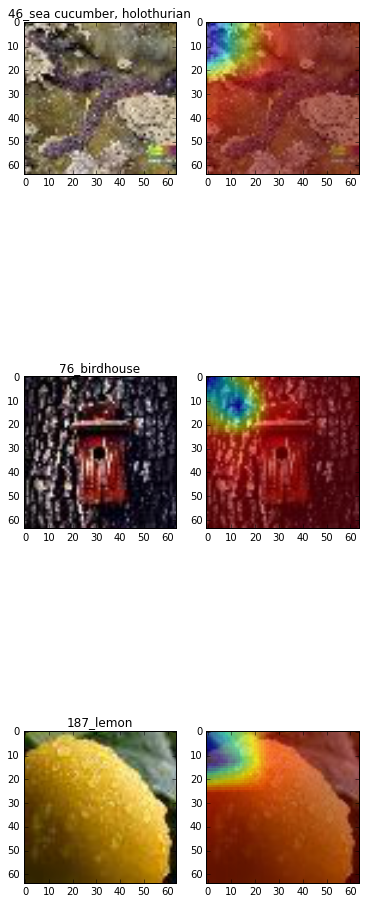

In [14]:
visualize_cam(X_sample.astype(np.uint8), Y_sample, cam_list_sample, idx_word_dict, n_show=3, start=0)

# Evaluation

In [15]:
(cam_list_train,
bbox_list_train,
gt_known_loc_accuracy_train,
top_1_loc_accuracy_train) = evaluate(model, X_train, P_train, Y_train_one_hot, 'train')

KeyboardInterrupt: 

In [ ]:
(cam_list_valid,
bbox_list_valid,
gt_known_loc_accuracy_valid,
top_1_loc_accuracy_valid) = evaluate(model, X_valid, P_valid, Y_valid_one_hot, 'valid')

In [ ]:
(cam_list_test,
bbox_list_test,
gt_known_loc_accuracy_test,
top_1_loc_accuracy_test) = evaluate(model, X_test, P_test, Y_test_one_hot, 'test')

# Visualization

In [ ]:
visualize(X_train, P_train, Y_train, cam_list_train, bbox_list_train, idx_word_dict,
          n_show=3, start=0)

In [ ]:
visualize(X_valid, P_valid, Y_valid, cam_list_valid, bbox_list_valid, idx_word_dict,
          n_show=3, start=0)

In [ ]:
visualize(X_test, P_test, Y_test, cam_list_test, bbox_list_test, idx_word_dict,
          n_show=3, start=0)